In [1]:
import os
os.environ["HADOOP_USER_NAME"] = "spark"
os.environ["SPARK_MAJOR_VERSION"] = "2"
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
import findspark
findspark.init()
import pyspark
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

In [2]:
file_name = "/user/maria_dev/datasets/CCPP/data.csv"
sc = pyspark.SparkContext(appName="LR")

In [3]:
sqlContext = SQLContext(sc)

In [4]:
data = sqlContext.read.options(header='true', inferschema='true', delimiter=',').csv(file_name)
data.cache()

DataFrame[AT: double, V: double, AP: double, RH: double, PE: double]

In [5]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|                AT|                 V|                AP|                RH|                PE|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              9568|              9568|              9568|              9568|              9568|
|   mean| 19.65123118729102| 54.30580372073601|1013.2590781772603| 73.30897784280926| 454.3650094063554|
| stddev|7.4524732296110825|12.707892998326784| 5.938783705811581|14.600268756728964|17.066994999803402|
|    min|              1.81|             25.36|            992.89|             25.56|            420.26|
|    max|             37.11|             81.56|            1033.3|            100.16|            495.76|
+-------+------------------+------------------+------------------+------------------+------------------+



In [6]:
features = ["AT", "V", "AP", "RH"]
lr_data = data.select(col("PE").alias("label"), *features)
lr_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)



In [7]:
vector = VectorAssembler(inputCols=features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
rfr = RandomForestRegressor(labelCol="label", featuresCol="scaled_features")

stages = [vector, scaler, rfr]

pipe = Pipeline(stages=stages)

In [8]:
estimatorParam = ParamGridBuilder() \
.addGrid(rfr.maxDepth, [4, 6, 8]) \
.addGrid(rfr.maxBins, [5, 10, 20, 40]) \
.addGrid(rfr.impurity, ["variance"]) \
.build()

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

In [9]:
crossval = CrossValidator(estimator=pipe,
                         estimatorParamMaps=estimatorParam,
                         evaluator=evaluator,
                         numFolds=3)

cvmodel = crossval.fit(lr_data)

In [10]:
model = pd.DataFrame(cvmodel.bestModel.stages[-1].featureImportances.toArray(), columns=["values"])
features_col = pd.Series(features)
model["features"] = features_col
model

,values,features
0,0.739691,AT
1,0.177243,V
2,0.065750,AP
3,0.017316,RH


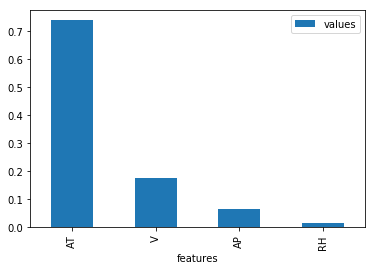

In [15]:
import matplotlib.pyplot as plt
model.set_index('features').plot(kind='bar')
plt.show()

In [12]:
print(type(lr_data))
print(type(feature_importance))
print(type(model))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
